# The No U-Turn Sampler

Hoffman & Gelman 2011: The No U-Turn Sampler
* implement algorithms 1 (basic HMC) & 6 (NUTS with dual averaging)
* test that your implementations work by replicating the following tests in Section 4.1:
 * 250-dimensional Gaussian
 * Bayesian logistic regression & hierarchical Bayesian logistic regression on the UCI german credit data
 * compare the results given by basic HMC & NUTS
 * compare your results with the same models run in Stan using the provided NUTS sampler
  * see e.g. mc-stan.org/users/interfaces/pystan.html

## General notes
Both the No-U-turn sampler and the HMC sampler only return latter half of the sample.
I've aimed at a between 50 and 60 percent acceptance rate for the accepted half.

To avoid variable names overlapping, each part resets the variables.

Functions for checking the convergence:
- ChainMix.py: between- and within chains mixing (BDA3, p. 284, formula 11.3); every chain is splitted into two halves, as the writers suggest in the footnote on p. 285

## Algorithm 1: Basic hamiltonian Monte Carlo
file: HMC.py

## Algorithm 6: Efficient No-U-Turn sampler
file: noUturnSampler.py

# Test case 0: simple linear regression
First test is a simple linear regression with coefficients alpha=theta[0]=10 and
beta=theta[1]=5. This test is for to roughly see that the sampler works.

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


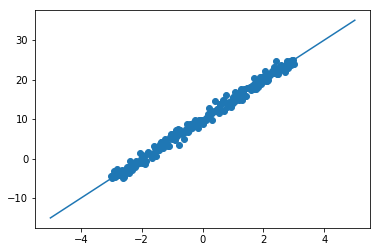

In [96]:
%reset
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd
import matplotlib.pyplot as plt
import noUturnSampler
import HMC
npr.seed(42)
# Always import the newest version of the samplers
import importlib
importlib.reload(noUturnSampler)
importlib.reload(HMC)

def LikelihoodTest0(theta, x, y, sigma2=1.0):
    return np.sum(-1/(2*sigma2)*(y-theta[0]-theta[1]*x)**2)

test0x=np.linspace(-3, 3, 200)
test0y=10+5*test0x+npr.normal(size=200)
# beta values for data generation are: [10, 5]
plt.scatter(test0x,test0y)
plt.plot(np.linspace(-5,5,200), 10+5*np.linspace(-5,5,200))

SimpleRegression=lambda x: LikelihoodTest0(x, test0x, test0y, sigma2=1.0)

### HMC

All in all accepted:  1000.0 , proportion:  1.0
Accepted:  499.0
Acceptance rate:  0.998
alpha:  9.951499692057542 beta:  5.030872427511103


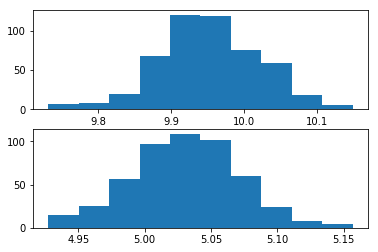

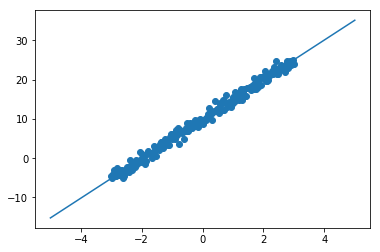

In [98]:
np.seterr('raise')
test0theta, test0r = HMC.basicHmc(np.array([-10.0, -10.0]), 0.001, 40, SimpleRegression, 1000)

print('alpha: ', np.mean(test0theta[:,0]), 'beta: ', np.mean(test0theta[:,1]))
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
ax2.hist(test0theta[:, 0])
ax3.hist(test0theta[:,1])

fig3, (plot1) = plt.subplots(nrows=1, ncols=1)
plot1.plot(np.linspace(-5,5,200), np.mean(test0theta[:,0])+np.mean(test0theta[:,1])*np.linspace(-5,5,200))
plt.scatter(test0x, test0y)

### No-U-Turn sampler

Alpha value:  9.960636513775752
Beta value:  5.038450641565703


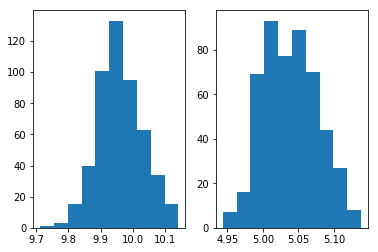

In [99]:
import importlib
importlib.reload(noUturnSampler)

np.seterr('raise')
# def NoUTurn(theta0, delta, fLikelihood, nSamples, nSamplesAdapt)
sample0UTurn, epsilonHist0=noUturnSampler.NoUTurn(np.array([1.0,1.0]), 0.60, SimpleRegression, 1000,500, testRun=False)

fig3, (plot1,plot2) = plt.subplots(nrows=1, ncols=2)
plot1.hist(sample0UTurn[:,0])
plot2.hist(sample0UTurn[:,1])
print('Alpha value: ',np.mean(sample0UTurn[:,0]))
print('Beta value: ', np.mean(sample0UTurn[50:,1]))

# Bayesian logistic regression

Metadata from Harvard data verse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/Q8MAW8

Original data from: https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data), using the file "german.data-numeric" version produced by Strathclyde University. Changes made: 
- changed the ordering of Attribute 3 (Credit History) to try to extract monotone relationship: ORIGINAL ORDERING: A30 : no credits taken/all credits paid back duly, A31 : all credits at this bank paid back duly, A32 : existing credits paid back duly till now, A33 : delay in paying off in the past, A34 : critical account/other credits existing (not at this bank)) NEW ORDERING: 0=all credits paid back (A31) 1=all credits paid back duly til now (A32) 2= no credits taken (A30) 3= delay in past (A33) 4=critical acct (A34). 


ATTRIBUTES: 
1 BalanceCheque
2 Loan NurnMonth
3 CreditHistory 
4 CreditAmt 
5 SavingsBalance 
6 Mths in PresentEmployment 
7 PersonStatusSex 
8 PresentResidenceSince 
9 Property 
10 AgeInYears 
11 OtherInstallmentPlans (highest val is NO other installment plans) 
12 NumExistingCreditsThisBank 
13 NumPplLiablMaint 
14 Telephone 
15 ForeignWorker 
16 Purpose-CarNew 
17 Purpose-CarOld 
18 otherdebtor-none (compared to guarantor) 
19 otherdebt-coappl (compared to guarantor) 
20 house-rent (compared to 'for free') 
21 house-owns (compared to 'for free') 
22 job-unemployed (vs mgt) 
23 jobs-unskilled (vs mgt) 
24 job-skilled (vs mgt) 

In [137]:
#%reset
import autograd.numpy as np
import autograd.numpy.random as npr
# Download data and standardize X
# Should have values 1 or -1
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import HMC
import noUturnSampler
import ChainMix
import Neff
import LikelihoodFunctions
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)
importlib.reload(LikelihoodFunctions)

npr.seed(42)
np.seterr('warn')

credit0= pd.read_csv('dataGerman.tab', delim_whitespace=True)

creditY=np.array(credit0['CREDITRATING'])
# Add alpha column=1.0 to make calculations easier
credit0.insert(0, 'alpha', np.ones(len(credit0)))
creditX0=np.array(credit0.loc[:, credit0.columns != 'CREDITRATING'])
creditX=(creditX0 - np.mean(creditX0, axis=0))/np.std(creditX0, axis=0)
creditX[:,0]=1.0

# Solve beta values for comparison
logistic = LogisticRegression(fit_intercept=False)
betaCoefficients=logistic.fit(creditX,creditY).coef_

lBayesLRX=lambda theta0: LikelihoodFunctions.lBayesLR(theta0, creditX, creditY)

C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


## HMC

In [113]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(25)
thetaOriginal2=npr.normal(-10.0, 5.0, 25)
thetaOriginal3=npr.normal(10.0, 5.0, 25)
thetaOriginal4=npr.normal(0.0, 5.0, 25)

# Sample size*2 (only the latter half is returned)
size=2000
hmcTheta0=np.empty([size//2, 25, 4])
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.08, 20, lBayesLRX, size)

All in all accepted:  1045.0 , proportion:  0.5225
Accepted:  524.0
Acceptance rate:  0.524
All in all accepted:  1014.0 , proportion:  0.507
Accepted:  523.0
Acceptance rate:  0.523


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: underflow encountered in exp
  return f_raw(*args, **kwargs)


All in all accepted:  1049.0 , proportion:  0.5245
Accepted:  519.0
Acceptance rate:  0.519
All in all accepted:  1061.0 , proportion:  0.5305
Accepted:  519.0
Acceptance rate:  0.519


### HMC: Chain mixing and effective sample size
RHat statistic describes the relation of between- and within-chain variances. Its value is 1 if the chains are perfectly mixed, but value 1.1 (as mentioned is the lecture notes) is considered to be sufficient as a an indicator for the convergence.

BDA3 suggests that sufficient effective sample size is at least 5m, so that there is at least 10 independent draws per sequence. (p 287)

RHat statistics for the parameters are:  [8.76323958 5.7452999  2.98924332 2.75952024 1.42923416 3.02700149
 1.7079029  1.5887599  1.00618274 1.55631392 1.25789276 2.20315335
 1.56003774 1.01960065 1.40853491 1.79369114 2.30021231 2.25476743
 1.96366706 1.78842439 1.18511738 1.04286989 1.23549491 1.00255344
 0.99987952]
vt0 (500, 25, 8)
tt (500,)
Effective sample size:  [   4.04740015    4.11150913    4.49788068    4.57107407    7.58165705
    4.46659157    5.93431079    6.36258744   45.79262338    6.49201827
   10.07952909    5.02773144    6.58013731   37.31284966    8.13190918
    5.720536      4.93829453    4.98410351    5.36648324    5.85774279
   13.23698296   46.56354734   11.05297893 2531.44655228 -146.52502214]


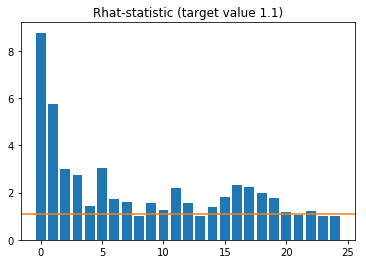

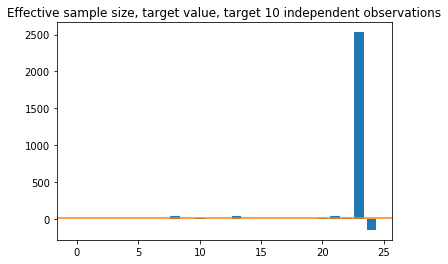

In [114]:
import ConvergenceTests
importlib.reload(ConvergenceTests)
hmcTheta1=ConvergenceTests.ConvergenceTest(hmcTheta0)


### HMC: Comparison with frequentist logistic regression coefficients

Logistic regression coefficients (without sampling):  [[-1.16693394 -0.72428117  0.41863996 -0.38950509  0.14971296 -0.36499316
  -0.17983097 -0.15223281  0.0088167   0.17896626 -0.10547967 -0.23223442
   0.1752658   0.02906784 -0.13173154 -0.25096542  0.26151383 -0.3013166
   0.29946551  0.24939256  0.12501634 -0.06082535 -0.08394011 -0.01848919
  -0.00851217]]
sample coefficients:  [-0.76523246 -0.46807478  0.27192755 -0.26366781  0.09780697 -0.24062262
 -0.11617878 -0.09701447  0.00421576  0.1183014  -0.06811993 -0.1504307
  0.1222396   0.01383896 -0.08541773 -0.16997234  0.16971056 -0.20107564
  0.20049388  0.16571356  0.08315543 -0.03701342 -0.0629756  -0.00998401
 -0.0045836 ]
absolute difference of the coefficients:  [[0.4  0.26 0.15 0.13 0.05 0.12 0.06 0.06 0.   0.06 0.04 0.08 0.05 0.02
  0.05 0.08 0.09 0.1  0.1  0.08 0.04 0.02 0.02 0.01 0.  ]]
(25,)


Text(0.5,1,'Absolute difference of logistic regression coefficients')

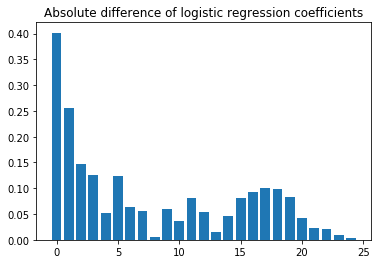

In [115]:
print('Logistic regression coefficients (without sampling): ', betaCoefficients)
hmcCoefficients=np.mean(hmcTheta1, axis=(0,2))
print('sample coefficients: ', hmcCoefficients)
print('absolute difference of the coefficients: ', np.round(abs(betaCoefficients-hmcCoefficients), 2))
height0=abs(betaCoefficients-hmcCoefficients)[0,:]
print(height0.shape)
plt.bar(range(len(height0)),height=height0)
plt.title('Absolute difference of logistic regression coefficients')

## NUTS sampler 

In [ ]:
import LikelihoodFunctions
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)
importlib.reload(LikelihoodFunctions)
# Reload noUturnSampler-script always anew.
import noUturnSampler
import importlib
importlib.reload(noUturnSampler)
np.seterr('warn')
np.seed(42)

lBayesLRX=lambda theta0: LikelihoodFunctions.lBayesLR(theta0, creditX, creditY)

# Sample size*2 (only the latter half is returned)
size=2000
nutsTheta0=np.empty([size//2, 25, 4])

# Print debugging info
testRun=False

# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(25)
thetaOriginal2=npr.normal(-10.0, 5.0, 25)
thetaOriginal3=npr.normal(10.0, 5.0, 25)
thetaOriginal4=npr.normal(0.0, 5.0, 25)

nutsTheta0[:,:,0], nutsEpsilon1 = noUturnSampler.NoUTurn(thetaOriginal1, 0.6, lBayesLRX, size,size//2, testRun)
nutsTheta0[:,:,1], nutsEpsilon2 = noUturnSampler.NoUTurn(thetaOriginal2, 0.6, lBayesLRX, size,size//2, testRun)
nutsTheta0[:,:,2], nutsEpsilon3 = noUturnSampler.NoUTurn(thetaOriginal3, 0.6, lBayesLRX, size,size//2, testRun)
nutsTheta0[:,:,3], nutsEpsilon4 = noUturnSampler.NoUTurn(thetaOriginal4, 0.6, lBayesLRX, size,size//2, testRun)

[-1.25456565 -0.45902624  1.13205258 -1.25456565 -1.25456565  1.13205258
  1.13205258 -0.45902624  1.13205258 -0.45902624 -0.45902624 -1.25456565
 -0.45902624 -1.25456565 -1.25456565 -1.25456565  1.13205258 -1.25456565
 -0.45902624  1.13205258  1.13205258 -1.25456565 -1.25456565 -0.45902624
  1.13205258 -1.25456565  1.13205258  0.33651317 -0.45902624 -1.25456565
 -0.45902624 -1.25456565 -0.45902624  1.13205258  0.33651317 -0.45902624
  1.13205258  0.33651317  0.33651317 -0.45902624  1.13205258 -0.45902624
 -0.45902624 -1.25456565 -1.25456565  1.13205258  1.13205258 -1.25456565
  1.13205258  1.13205258 -0.45902624 -0.45902624  1.13205258  1.13205258
 -0.45902624  1.13205258 -0.45902624  1.13205258  0.33651317 -1.25456565
 -0.45902624 -0.45902624 -0.45902624 -0.45902624  1.13205258  1.13205258
  1.13205258 -0.45902624  1.13205258  1.13205258  1.13205258  1.13205258
 -1.25456565 -0.45902624 -1.25456565 -1.25456565 -1.25456565 -0.45902624
  1.13205258 -0.45902624  1.13205258  1.13205258  1

### NUTS: Chain mixing

In [ ]:
%matplotlib inline
nutsTheta1=ConvergenceTests.ConvergenceTest(nutsTheta0)

In [141]:
test=np.array([1.0,2.0,3.0,4.0,1.0,2.0,3.0,4.0])
test[test<3]=0
test.shape

(8,)

### NUTS: comparison of the regression coefficients

In [83]:
print('Logistic regression coefficients (without sampling): ', betaCoefficients)
nutsCoefficients=np.mean(nutsTheta1, axis=(0,2))
print('sample coefficients: ', nutsCoefficients)
print('absolute difference of the coefficients: ', np.round(abs(betaCoefficients-nutsCoefficients), 2))
height0=abs(betaCoefficients-nutsCoefficients)[0,:]
print(height0.shape)
plt.bar(range(len(height0)),height=height0)
plt.title('Absolute difference of logistic regression coefficients')

Logistic regression coefficients (without sampling):  [[-1.16693394 -0.72428117  0.41863996 -0.38950509  0.14971296 -0.36499316
  -0.17983097 -0.15223281  0.0088167   0.17896626 -0.10547967 -0.23223442
   0.1752658   0.02906784 -0.13173154 -0.25096542  0.26151383 -0.3013166
   0.29946551  0.24939256  0.12501634 -0.06082535 -0.08394011 -0.01848919
  -0.00851217]]


NameError: name 'nutsTheta1' is not defined

# Test case 3: Hierarchical bayesian logistic regression
* Same data as above

In [25]:
%reset
import autograd.numpy as np
import autograd.numpy.random as npr
# Download data and standardize X
# Should have values 1 or -1
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import HMC
import noUturnSampler
import ChainMix
import Neff
import ConvergenceTests
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)
importlib.reload(ConvergenceTests)

credit0= pd.read_csv('dataGerman.tab', delim_whitespace=True)
creditY=np.array(credit0['CREDITRATING'])
credit0.insert(0, 'alpha', np.ones(len(credit0)))
creditX0=np.array(credit0.loc[:, credit0.columns != 'CREDITRATING'])
creditX=(creditX0 - np.mean(creditX0, axis=0))/np.std(creditX0, axis=0)
creditX[:,0]=1.0

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [26]:
# First parameter in theta is variance
# Rest are beta coefficients
def lBayesHLR(theta, x, y, lambda0=0.01):
    sigma2=np.exp(theta[0])
    beta=theta[1:]
    prob1=-np.sum(np.log(1+np.exp(-(y[:, np.newaxis]*x)@beta)))-1/(2*sigma2)*beta@beta-len(y)/2*np.log(sigma2)-lambda0*sigma2
    return prob1


lBayesHLRX=lambda theta0: lBayesHLR(theta0, creditX, creditY)

### HMC

In [27]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(26)
thetaOriginal2=npr.normal(-10.0, 5.0, 26)
thetaOriginal3=npr.normal(10.0, 5.0, 26)
thetaOriginal4=npr.normal(0.0, 5.0, 26)

# Sample size*2 (only the latter half is returned)
size=200
hmcTheta0=np.empty([size//2, 26, 4])
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.01, 50, lBayesHLRX, size)
hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.01, 50, lBayesHLRX, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.01, 50, lBayesHLRX, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.01, 50, lBayesHLRX, size)


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:73: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)


All in all accepted:  184.0 , proportion:  0.92
Accepted:  99.0
Acceptance rate:  0.99


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\core.py:205: RuntimeWarning: invalid value encountered in double_scalars
  def _mut_add(self, x, y):    x += y; return x


All in all accepted:  200.0 , proportion:  1.0
Accepted:  99.0
Acceptance rate:  0.99
All in all accepted:  183.0 , proportion:  0.915
Accepted:  99.0
Acceptance rate:  0.99
All in all accepted:  195.0 , proportion:  0.975
Accepted:  99.0
Acceptance rate:  0.99


RHat statistics for the parameters are:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
vt0 (50, 26, 8)
tt (50,)
Effective sample size:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]


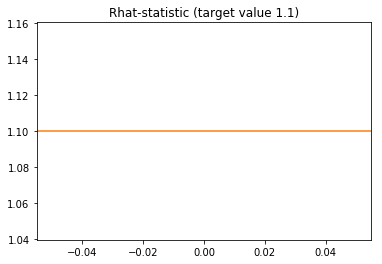

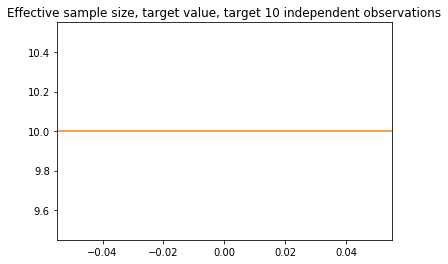

In [28]:
ConvergenceTests.ConvergenceTest(hmcTheta0)

### NUTS

In [30]:
# Sample size*2 (only the latter half is returned)
size=200
hmcTheta0=np.empty([size//2, 26, 4])
nutsTheta0[:,:,0], nutsEpsilon1 = noUturnSampler.NoUTurn(thetaOriginal1, 0.6, lBayesHLRX, size,size//2, testRun=False)
nutsTheta0[:,:,1], nutsEpsilon2 = noUturnSampler.NoUTurn(thetaOriginal2, 0.6, lBayesHLRX, size,size//2, testRun=False)
nutsTheta0[:,:,2], nutsEpsilon3 = noUturnSampler.NoUTurn(thetaOriginal3, 0.6, lBayesHLRX, size,size//2, testRun=False)
nutsTheta0[:,:,3], nutsEpsilon4 = noUturnSampler.NoUTurn(thetaOriginal4, 0.6, lBayesHLRX, size,size//2, testRun=False)

C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


OverflowError: Range exceeds valid bounds

# Test case 4: compare your results with the same models run in Stan using the provided NUTS sampler
Pystan downloaded from :mc-stan.org/users/interfaces/pystan.html

## Test case 1: 250 dimensional multivariate normal

In [27]:
def fLNormal250(parTheta, matrixA):
    return -1/2*parTheta.T @ matrixA @ parTheta

# Generate 250*250 matrix for multivariate normal-distribution
from scipy.stats import wishart
precisionMatrixA=wishart.rvs(df=2, scale=1, size=[2, 2], random_state=None)
normal250likelihood=lambda x: fLNormal250(x, matrixA=precisionMatrixA)

# Generate 250*1 vector as starting values for theta
thetaOriginal=npr.normal(3.0, 3.0, size=2)


### HMC

In [13]:
import importlib
import HMC
importlib.reload(HMC)
thetaSample, rSample = HMC.basicHmc(thetaOriginal, 0.01, 100, normal250likelihood, 2000)

All in all accepted:  0.0 , proportion:  0.0
Accepted:  0.0
Acceptance rate:  0.0


In [36]:
print(thetaSample)

[[ 2.65564517 -5.39012071  7.46617946 ... -0.58202115  3.41668296
   0.82154097]
 [ 2.65564517 -5.39012071  7.46617946 ... -0.58202115  3.41668296
   0.82154097]
 [ 2.65564517 -5.39012071  7.46617946 ... -0.58202115  3.41668296
   0.82154097]
 ...
 [ 4.37834002 -8.7020084  12.86806496 ...  0.55830722  4.79958405
  -0.95769674]
 [ 4.39589425 -8.74859041 12.92832518 ...  0.57004154  4.81361664
  -0.97790908]
 [ 4.41621365 -8.7830764  12.98497566 ...  0.58387645  4.82169907
  -1.00058265]]


### No-U-Turn sampler

In [40]:
import noUturnSampler
import importlib
importlib.reload(noUturnSampler)
sample1UTurn, epsilon1sample=noUturnSampler.NoUTurn(thetaOriginal, 0.60, normal250likelihood, 1000,500, testRun=True)

#fig3, (plot1,plot2) = plt.subplots(nrows=1, ncols=2)
#plot1.hist(sample0UTurn[:,0])
#plot2.hist(sample0UTurn[:,1])
#print('Alpha value: ',np.mean(sample0UTurn[:,0]))
#print('Beta value: ', np.mean(sample0UTurn[:,1]))

First epsilon:  0.05
High bound Likelihood:  -128.01788087995303  , 1/2*r0@r0:  0.13292098339001115
***Starting iteration, round:  1
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -127.61444453914325
compared to Likelihood(theta0):  -128.01788087995303
Accepted new theta value, round, theta:  1 [7.72982777 5.2826722 ]
Accepted likelihood:  -127.61444453914325
High bound Likelihood:  -127.61444453914325  , 1/2*r0@r0:  0.5495025917901689
***Starting iteration, round:  2
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -64.65504521034924
compared to Likelihood(theta0):  -127.61444453914325
Accepted new theta value, round, theta:  2 [-6.5174443  -1.20169193]
Accepted likelihood:  -64.65504521034924
Going to direction:  1
j-value is:  1.0
Accepted thetaCur2, Likelihood:  -8.653779005917047
BuildTree: j!=1, Likelihood(thetaCur) -8.653779005917047
High bound Likelihood:  -64.65504521034924  , 1/2*r0@r0:  0.21583008068611892
***Starting iteration, round:  3
Going to 

FloatingPointError: invalid value encountered in double_scalars

In [37]:
np.exp(-700.0)

9.85967654375977e-305